<a href="https://colab.research.google.com/github/rennishi7/Well_Imputation/blob/master/Data_Imputation_Compiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Groundwater Data Imputation and Interpolation Script

#####This notebook contains a machine learning algorithm designed to impute data within a set of groundwater wells. The data can then be spatially interpolated to create a groundwater surface raster. Finally, a storage depletion curve can be calculated.

#####It requires as input: 
* an aquifer shapefile
* well locations and observational measurements
* PDSI and GLDAS datasets (link in script)

##### You will also need access to a Google Drive account.



---

<a name="loadUtils"></a>
## **Step 0: Load packages and files**
*This section should be run whenever a new session is started.*

### <font color='dimgray'>Install and load packages and utility files</font>

In [ ]:
#@markdown ### **Run this cell to install the proper packages**
# Creating Environment 1: Spatial (Should handle steps 1-5)
%%capture
!pip install fiona
!pip install rasterio
!pip install h5py
!pip install geopandas
!pip install grids
!pip install scikit-learn
!pip install EMD-signal
!pip install tables
!pip install pickle5
!pip install gstools

In [ ]:
#@markdown ### **Run this cell to import all necessary packages to the session**

from google.colab import files
import os
import ipywidgets as widgets
import shutil
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PyEMD import EEMD
import ee
import numpy as np
import math
import sys
import datetime
import pickle
import netCDF4 as nc

In [ ]:
#@markdown ### **Run this cell to import the utility files from Github**

# Importing utility files from github
import requests
#usd_url = 'https://raw.githubusercontent.com/rennishi7/Well_Imputation/master/Master%20Code/utils_satellite_data.py'
usd_url ='https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_satellite_data.py'
#wf_url = 'https://raw.githubusercontent.com/rennishi7/Well_Imputation/master/Master%20Code/utils_well_data.py'
wf_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_well_data.py'
da_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_data_augmentation.py'
ml_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_machine_learning.py'
sp_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_spatial.py'
url_set = [usd_url, wf_url, da_url, ml_url, sp_url]

# Load the utility files into the session
for url in url_set:
  r = requests.get(url)
  with open(url.rsplit('/', 1)[-1], 'w') as f:
    f.write(r.text)

import utils_satellite_data as usd
import utils_well_data as wf 
import utils_data_augmentation
import utils_machine_learning
import utils_spatial

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


### <font color='dimgray'>Load aquifer shapefile</font>

In [ ]:
#@markdown ### **Run this cell to load the aquifers shapefile**

print("Upload the aquifer shapefile files (including .shp, .shx, and .dbf):\n")
uploaded = files.upload()
!mkdir Aquifer_Shapes Aquifers_Data Datasets
for aqFile in uploaded.keys():
  os.rename('/content/'+aqFile,'/content/Aquifer_Shapes/'+aqFile)

Upload the aquifer shapefile files (including .shp, .shx, and .dbf):



Saving CA_118_GW_Basins-1_Aquifer.dbf to CA_118_GW_Basins-1_Aquifer.dbf
Saving CA_118_GW_Basins-1_Aquifer.prj to CA_118_GW_Basins-1_Aquifer.prj
Saving CA_118_GW_Basins-1_Aquifer.shp to CA_118_GW_Basins-1_Aquifer.shp
Saving CA_118_GW_Basins-1_Aquifer.shx to CA_118_GW_Basins-1_Aquifer.shx


---

## **Table of Contents**
Follow links to jump to specific sections

* [Step 0: Load packages and files](#loadUtils)
* [Step 1: Satellite Data Preparation](#satData)
* [Step 2: Prepare Wells Data for Imputation](#prep)
* [Step 3: Impute Data](#impute)
* [Step 4: Spatial Interpolation](#spatial)
* [Step 5: Storage Depletion Calculation](#storage)

<a name="satData"></a>
## **Step 1: Satellite Data Preparation**

**The PDSI and GLDAS datasets are provided via a shared Google Drive folder, found here:**
https://drive.google.com/drive/folders/1hSN6gkp9zmFYUwMOdDIj8pa-KqBjN8JW?usp=sharing

*You should save a shortcut to your own Google Drive and then determine the file path to the folder.*

In [ ]:
#@markdown ### **Run this cell to mount your Google Drive to access PDSI and GLDAS files**
from google.colab import drive
print("FOLLOW THE URL LINK BELOW\n")
drive.mount('/content/drive')

FOLLOW THE URL LINK BELOW

Mounted at /content/drive


### <font color='dimgray'>PDSI Data Prep</font>

In [ ]:
#@markdown ### **Run the cell and define the path to the Satellite Data * folder ***

def saveText(button):
  global satDataPath
  satDataPath = satDataPath_widget.value
  print('\rPath to Groundwater_Imputation_-_Satellite_Data FOLDER (not an individual file): "%s"' %(satDataPath), end='')

satDataPath_widget = widgets.Text(placeholder='File path to Satellite Data', description='File path:', disabled=False)
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveText)
print('File path to Groundwater_Imputation_-_Satellite_Data folder (e.g. /content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data)\n\n(Tip: you can navigate to the folder on your Google Drive from the "Files" panel on the left and click on the three dots next to the folder and select "Copy path")\n')
widgets.VBox([satDataPath_widget, button])

File path to Groundwater_Imputation_-_Satellite_Data folder (e.g. /content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data)

(Tip: you can navigate to the folder on your Google Drive from the "Files" panel on the left and click on the three dots next to the folder and select "Copy path")



Path to Groundwater_Imputation_-_Satellite_Data FOLDER (not an individual file): "/content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data"

In [ ]:
#@markdown ### **Run this cell to parse the PDSI data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# Set data location. If location does not exist, class initialization will create it.
data_root = '/content/Datasets/'
#ts_date_start = '1850-01-01'
ts_date_start = '1948-01-01'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(77.5, -60.0, 180.0, -180.0, 2.5, 2.5)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')
# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Create index from starting date until X weeks from present day.
dates = utils.Date_Index_Creation(ts_date_start)

# The grids_netCDF class is used to handle either the GLDAS or SC PDSI PM dataset
# The file structures are very different. Areas that have missing values, GLDAS
# will treat as NAN, while pdsi treats as mask 'None'. PDSI is a single variable file
# while GLDAS is a multi-variable file per month.

# File_String refers to the data being located with a single string, or list of strings
# Variable String, referes to the variables being within a string or text file.
parse = usd.grids_netCDF(File_String=True, Variable_String=True)

#====================================================================
# Location of single netCDF file.
#data_path = satDataPath + '/PDSI/sc_PDSI_pm/pdsisc.monthly.maps.1850-2018.fawc-1.r2.5x2.5.ipe-2.nc'
data_path = satDataPath + '/PDSI/sc_PDSI_pm/pdsi_ramirez_hales_williams.nc4'
#====================================================================

# Name of variables of interest within file.
#variables = 'sc_PDSI_pm'
variables = 'pdsi_filled'

# Parse_Data is a nested loop using the grids python package. For every cell, grabs
# every specified variable. Then parses the variable assigning it to the correct cell
# For PDSI use Mask, dates, data_path, and variable name.
# For GLDAS use Mask, dates, data_folder, file_list, variables_list

#   Mask: dictionary with locations. 
#   dates: datetimeindex, used to index dataframe
#   data_path: Location of netcdf if it is a single file, else None
#   data_folder: The folder containing the individual netcdf files.
#   file_list: variable string=False, text file location with netcdf names
#   variable_name: Names of variables wanted parse.
#   variables_list: location of file with variable names. 

Data = parse.Parse_Data(mask, dates, data_path = data_path, variable_name=variables)

# Validates that all data exists, removes nans and Nones from time series,
# as well as the location dataframe.
Data = parse.Validate_Data(mask, Data)
print(Data.keys())
# Final Save.
utils.Save_Pickle(Data,'PDSI_Data', data_root)
print('Success!')

Starting Cell Selection...
Cells Found.
Loading netCDF location.
Creating Variables
Variable List Made.
Preparing to parse Data.
Working on pdsi_filled 1/1
Parsing Cell_2198 1/9
Parsing Cell_2199 2/9
Parsing Cell_2200 3/9
Parsing Cell_2343 4/9
Parsing Cell_2344 5/9
Parsing Cell_2345 6/9
Parsing Cell_2488 7/9
Parsing Cell_2489 8/9
Parsing Cell_2490 9/9
Validating Data.
Removed Cell Cell_2343
Removed Cell Cell_2488
Data Validated.
dict_keys(['Cell_2198', 'Cell_2199', 'Cell_2200', 'Cell_2344', 'Cell_2345', 'Cell_2489', 'Cell_2490', 'Location'])
Success!


In [ ]:
#@markdown ### **(Optional) Run this cell to download PDSI pickle files to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/PDSI_Data.pickle')
files.download('/content/Datasets/PDSI_Data_Not_Validated.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  <font color='dimgray'>EEMD Feature Creation from PDSI</font>

In [ ]:
#@markdown ### **Run this cell to create PDSI Intrinsic Mode Functions (IMFs) using EEMD**

# The purpose of this script is to load data and calculate intrinsic mode functions
# (imfs) and coressponding residual using Ensemble Empirical Mode Decomposition 
# (EEMD). This analysis decomposes a signal into components that create time 
# aspect for original signal. This accounts for much of the groundwater accuracy.

# Data Locations
data_root ="./Datasets/"
figures_root = './Figures EEMD'

# Importing well object class
DA = utils_data_augmentation.Data_Augmentation(data_root, figures_root)

# Load pickle Data
Data = DA.read_pickle('PDSI_Data', data_root)
cell_names = list(Data.keys())
cell_names.remove('Location')


# Code is flexible enough to handle multiple cells with multiple variables
# such as GLDAS. That is why we use nested loop even though PDSI is a single
# variable. Load cell.
for i, cell in enumerate(cell_names):
    data_temp = Data[cell]
    
    # Load EEMD class.
    for j, var in enumerate(data_temp.columns):
        if __name__ == "__main__":
            eemd = EEMD(trials= 10, noise_width = 0.05, ext_EMD=None, 
                        parallel = False, separate_trends=False)
            eIMF = eemd(data_temp[var].values).T #Transverse to match with index

        # Convert pdsi EEMD numpy array to Pandas Dataframe to keep indecies.
        eIMF = pd.DataFrame(eIMF, index=data_temp.index)
        label = [var + '_imf_' + str(k+1) for k in range(len(eIMF.columns))]
        eIMF = eIMF.set_axis(label, axis=1, inplace=False)
        data_temp = data_temp.join(eIMF, how='outer')
        
        # Replace cell data with recalculated values        
        Data[cell] = data_temp
        
        # Plot EEMD Results
        fig, axs = plt.subplots(nrows= eIMF.shape[1]+1, ncols=1, figsize=(12,18))
        fig.suptitle(str('Ensemble Empirical Mode Decomposition: ' + cell +' ' + var))
        plt.subplots_adjust(top=.95, hspace=0.25)
        plot_labels = ['IMF '+str(k) if k>0 else var for k in range(len(data_temp.columns))]
        for k, _ in enumerate(data_temp):
            axs[k].plot(data_temp.index, data_temp[data_temp.columns[k]])
            axs[k].set(ylabel = plot_labels[k])
        plt.show()
        
        # Save Figure
        fig_namepng = figures_root + '/' + str(cell) + '_EEMD' + '.png'
        fig.savefig(fig_namepng, format="png", dpi=600 )

# Save pickle file
DA.Save_Pickle(Data, 'PDSI_Data_EEMD')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the PDSI EEMD pickle file to local machine**
files.download('/content/Datasets/PDSI_Data_EEMD.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <font color='dimgray'>GLDAS Data Prep</font>

This step will take 30-60 mins. As such, it is recommended that you set your computer settings to not go to sleep or open a program (e.g. YouTube) that will keep it awake for the full time. The files generated by this step will automatically download so that you can re-upload to your Colab session afterwards.

In [ ]:
#@markdown ### **Run this cell to parse the GLDAS data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# data_root is the location where data will be saved
data_root = '/content/Datasets/'
file_list = satDataPath + '/Sat_Data_Prep_Ref_Files/subset_GLDAS_NOAH025_M_2.0_20210628_013227.txt'

# shape_location is the location to the Shape file
shape_location = '/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp'
# gldas_root is the location of folder containing the tabulated GLDAS
gldas_root = satDataPath + r'/GLDAS_Tabular'

# variables_list_loc the text file containing the GLDAS variable names
variables_list_loc = satDataPath + '/Sat_Data_Prep_Ref_Files/variables_list.txt'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(89.875, -59.875, 179.875, -179.875, 0.25, 0.25)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary(shape_location)

# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Construct list of cell names within shapefile
cell_names = list(cell_names.keys())
# Create GLDAS Parsing class
GLDAS_parse = usd.GLDAS_parse(gldas_root, cell_names)
# Open variable text file, load data, convert to list
variables_list = GLDAS_parse.Variable_List(variables_list_loc)
# Create subset of GLDAS variable columns based on mask
Variable_Dictionary = GLDAS_parse.Open_GLDAS(variables_list, mask)
# Split variables into cells and store them into a dictionary along with location
Data = GLDAS_parse.parse(Variable_Dictionary, mask)
print(Data.keys())

# Save data
utils.Save_Pickle(Data,'GLDAS_Data', data_root)

print('Success!')

Starting Cell Selection...
Cells Found.
Variable List Made.
Parsing Cell_299784 1/6
Parsing Cell_299785 2/6
Parsing Cell_299786 3/6
Parsing Cell_301224 4/6
Parsing Cell_301225 5/6
Parsing Cell_301226 6/6
dict_keys(['Cell_299784', 'Cell_299785', 'Cell_299786', 'Cell_301224', 'Cell_301225', 'Cell_301226', 'Location'])


In [ ]:
#@markdown ### **(Optional) Run this cell to download GLDAS pickle files to local machine**
files.download('/content/Datasets/GLDAS_Data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <font color='dimgray'>GLDAS Data Augment</font>

In [ ]:
#@markdown ### **Run this cell to augment the GLDAS data with forward rolling windows of 1, 3, and 5 years**
# This script will calculate modifications to datasets. Particularly this
# loads the GLDAS Data pickle file, and performs a forward rolling window.
# This will cause the data to lose months of data equivalating to the largest
# window size. 

# Importing well object class
DA = utils_data_augmentation.Data_Augmentation(figures_root = '/content')

# Load GLDAS Data
Data = DA.read_pickle('GLDAS_Data', root = './Datasets/')
cell_names = list(Data.keys())
cell_names.remove('Location') # Remove location

# Loop through every cell in the dataset performing augmentations. We only used
# FRWA, however, offsets and cumulative averages are available.
for i, cell in enumerate(cell_names):
    data_temp = Data[cell] 
    data_temp = DA.Rolling_Window(data_temp, data_temp.columns, years=[1, 3, 5])
    Data[cell] = data_temp

# Save Data
DA.Save_Pickle(Data, 'GLDAS_Data_Augmented')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the well pickle file and well points h5 file to local machine**
files.download('/content/Datasets/GLDAS_Data_Augmented.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="prep"></a>
## **Step 2: Wells Data Preparation**


[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Select pickle option below and run this cell to create/load your pickle file**
#@markdown ##### *Select your pickle creation/upload option below*
Pickle_Upload_Type = "1) Create your pickle file" #@param ["1) Create your pickle file", "2) Upload an existing pickle file from Google Drive (recommended for 100+ MB files)", "3) Upload existing pickle file from computer"]
# Load data pickle (it must contain 3 df's: centroid of wells, well locations, well measurements)
if Pickle_Upload_Type[0:1] == '1':
  print('Proceed to next section.')
elif Pickle_Upload_Type[0:1] == '2':
  def saveText(button):
    global pickleFilePath
    pickleFilePath = pickleFilePath_widget.value
    print('\rFile Path = "%s"' %(pickleFilePath), end='')
    shutil.copy(pickleFilePath,'/content/Aquifers_Data/' + pickleFilePath.rsplit('/', 1)[-1])
  pickleFilePath_widget = widgets.Text(placeholder='Path to File', description='File Path:', disabled=False)
  button = widgets.Button(description='Save', disabled=False)
  button.on_click(saveText)
  display(widgets.VBox([pickleFilePath_widget, button]))
else:
  print("Upload the pickle file with well locations, centroid, and time series measurements:\n")
  uploaded = files.upload()
  data_file = ''.join(uploaded)
  os.rename('/content/'+data_file,'/content/Aquifers_Data/'+data_file)
  pickleFilePath = '/content/Aquifers_Data/'+data_file

### <font color='dimgray'>Wells Data - Pickle File Creation</font>
This section can be used for preparing a pickle file for wells data preparation. It requires a wells file and a time series file as inputs (.csv files) and creates one output file (.pickle). If you have already uploaded an existing pickle file, you can skip this subsection and go to the 'Wells Data Prep' subsection.

In [ ]:
#@markdown ### **Define the file name of the pickle file that will be created, then run the cell**
picklefilename = 'CA_JPL' #@param {type:"string"}

# Set the dates as dates and sort in ascending order
tms_df[date] = pd.to_datetime(tms_df[date])
tms_df.sort_values(by=[date], inplace=True)

numWells = len(tms_df.drop_duplicates([tms_wellID]))
numDates = len(tms_df.drop_duplicates([date]))
numDups = len(tms_df.drop_duplicates([tms_wellID, date]))
#print('There are %d unique wells, %d unique dates, and %d unique entries (with a unique well ID and date combo).' % (numWells, numDates, numDups))
#print('The shape of the matrix:' + ' ' + str(tms_df.shape))

# Create the NxM matrix (where N = number of unique dates with values; M = number of unique well IDs)
tms_df_matrix = pd.pivot_table(tms_df, index=date, values=var, columns=tms_wellID)
#print(sum(tms_df_matrix.count()), "values in the matrix\n(Values from the same well and date are averaged)\n")
#print('The shape of the matrix:' + ' ' + str(tms_df_matrix.shape))
#====================================================================

# Create locations df
unique_wells_df = wls_df.drop_duplicates(wls_wellID).merge(tms_df.drop_duplicates(tms_wellID)[tms_wellID], left_on=wls_wellID, right_on=tms_wellID)
unique_wells_df.rename(columns={long: "Longitude", lat: "Latitude"}, inplace=True)
unique_wells_df = unique_wells_df[[wls_wellID, 'Latitude', 'Longitude']].set_index(wls_wellID)
unique_wells_df

# Calculate centroid
centroid_df = pd.DataFrame([0,0], index=(['Longitude','Latitude']))
lonAvg, latAvg = unique_wells_df['Longitude'].mean(), unique_wells_df['Latitude'].mean()
centroid_df.loc['Longitude'], centroid_df.loc['Latitude'] = lonAvg, latAvg

def Pandas_to_Pickle(combined_df, location_df, centroid, name):
    Aquifer = {'Data':combined_df, 'Location':location_df, 'Centroid':centroid}
    pickle_name = name + '.pickle'
    with open(pickle_name, 'wb') as handle:
        pickle.dump(Aquifer, handle)
    return Aquifer
pickleData = Pandas_to_Pickle(tms_df_matrix, unique_wells_df, centroid_df, picklefilename)
pickleFilePath = '/content/Aquifers_Data/'+picklefilename+'.pickle'
os.rename('/content/'+picklefilename+'.pickle', pickleFilePath)

In [ ]:
#@markdown ### **Define the file name of the pickle file that will be created, then run the cell**
picklefilename = 'Type your file name here' #@param {type:"string"}

# Set the dates as dates and sort in ascending order
tms_df[date] = pd.to_datetime(tms_df[date])
tms_df.sort_values(by=[date], inplace=True)

numWells = len(tms_df.drop_duplicates([tms_wellID]))
numDates = len(tms_df.drop_duplicates([date]))
numDups = len(tms_df.drop_duplicates([tms_wellID, date]))
#print('There are %d unique wells, %d unique dates, and %d unique entries (with a unique well ID and date combo).' % (numWells, numDates, numDups))
#print('The shape of the matrix:' + ' ' + str(tms_df.shape))

# Create the NxM matrix (where N = number of unique dates with values; M = number of unique well IDs)
tms_df_matrix = pd.pivot_table(tms_df, index=date, values=var, columns=tms_wellID)
#print(sum(tms_df_matrix.count()), "values in the matrix\n(Values from the same well and date are averaged)\n")
#print('The shape of the matrix:' + ' ' + str(tms_df_matrix.shape))
#====================================================================

# Create locations df
unique_wells_df = wls_df.drop_duplicates(wls_wellID).merge(tms_df.drop_duplicates(tms_wellID)[tms_wellID], left_on=wls_wellID, right_on=tms_wellID)
unique_wells_df.rename(columns={long: "Longitude", lat: "Latitude"}, inplace=True)
unique_wells_df = unique_wells_df[[wls_wellID, 'Latitude', 'Longitude']].set_index(wls_wellID)
unique_wells_df

# Calculate centroid
centroid_df = pd.DataFrame([0,0], index=(['Longitude','Latitude']))
lonAvg, latAvg = unique_wells_df['Longitude'].mean(), unique_wells_df['Latitude'].mean()
centroid_df.loc['Longitude'], centroid_df.loc['Latitude'] = lonAvg, latAvg

def Pandas_to_Pickle(combined_df, location_df, centroid, name):
    Aquifer = {'Data':combined_df, 'Location':location_df, 'Centroid':centroid}
    pickle_name = name + '.pickle'
    with open(pickle_name, 'wb') as handle:
        pickle.dump(Aquifer, handle)
    return Aquifer
pickleData = Pandas_to_Pickle(tms_df_matrix, unique_wells_df, centroid_df, picklefilename)
pickleFilePath = '/content/Aquifers_Data/'+picklefilename+'.pickle'
os.rename('/content/'+picklefilename+'.pickle', pickleFilePath)

### <font color='dimgray'>Wells Data Prep</font>

In [ ]:
#@markdown ### **Run this cell to filter, resample, and interpolate observed well data**
#@markdown ---
#@markdown #### Specify minimum number of unique observation months
#@markdown *In order to filter out wells that do not have sufficient data, a minimum number of unique observation months (i.e. unique months with at least 1 observation) is required.* **All wells that do not meet this threshold will be discarded.**
Minimum_Observation_Months = 50 #@param {type:"integer"}
#@markdown ---
#@markdown #### Specify the pad size
#@markdown *The pad size determines the length of time (in days) after an observation that data will be interpolated*
Pad_Size = 90 #@param {type:"integer"}
 
# This script opens preprocessed pickle file containing 3 DataFrames: Centroid,
# Well Timeseries, and well location.
# High level does 3 things:
# 1: Extracts Well Time series, and drops any well without a minimum amount
#    of Data within a user specified window
# 2: Interpolates subset of data, removing gaps larger than user specified size
#    Gaps will be filled in using a machine learning algorithm. This step
#    is based on the assumption that groundwater changes are slow, and readings
#    will remain valid for a time period after the original reading.
# 3: Contains support functions of data augmentation such as Rolling-Window 
#    averages and plotting. 

# Data Locations
data_root =    '/content/Datasets/'
aquifer_root = '/content/Aquifers_Data'
figures_root = '/content/Figures Aquifer'

# Location must be added
Wells=wf.wellfunc(data_root, aquifer_root, figures_root)

# read the well data from a pickle file
raw_wells_dict = Wells.read_well_pickle(pickleFilePath.rsplit('/', 1)[-1][:-7])

# extractwelldata extracts waterlevel measurements and creates a panda data 
# Bcap and Fcap are bottom and final cap, this control guarrenties that wells
# will contain data before and after the caps
# MinEx is the minimum number examples required within dataset
# extract the data into a panda data frame
wells_dict = Wells.extractwelldata(raw_wells_dict, Left=1948, Right=2021, Min_Obs_Months=Minimum_Observation_Months)          

# now need to resample well data to begining of month ('1MS') or chosen period
# next most used will be 'QS' Quarter Start Frequency
# need to fill with NaNs on large gaps
# interpolate the well data to regular interval
# do not interpolate for large gaps (gap size can be set in function)
# provide data on either side of measured data - no nans - can be set in func
# can select data interval in function
wells_dict['Data'] = Wells.interp_well(wells_dict['Data'], gap_size = '365 days', pad = Pad_Size, spacing = '1MS')

# Plot Well Results
Wells.well_plot(wells_dict['Data'], wells_dict['Data'], plot_wells= True)  # plot the data to look at

#Save Datasets
Wells.Save_Pickle(wells_dict, 'Well_Data')
wells_dict['Data'].to_hdf(data_root + '03_Original_Points.h5', key='df', mode='w')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the well pickle file and well points h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data.pickle')
files.download('/content/Datasets/03_Original_Points.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="impute"></a>

## **Step 3: Data Imputation**

This step may take anywhere from a few minutess to a few hours, depending on how many wells you have (that weren't filtered out). The script processes about 2.5 wells per minute.

We recommend that when you run each cell, you also run the optional file download cell at the end of the section so that you don't lose your work.

[Load packages and utility files](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to load a new environment to perform data imputation**
import pandas as pd
import numpy as np
import utils_machine_learning
import warnings
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import RootMeanSquaredError, mean_absolute_error

print('Success!')

Success!


In [ ]:
#@markdown ### **Run this cell to upload files (if starting from a new session)**
Upload_Files = False #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
  print("Upload Well_Data pickle file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload 03_Original_Points.h5 file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload PDSI_Data_EEMD pickle file from step 1\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload GLDAS_Data_Augmented pickle file from step 1\n(The file may take several minutes to upload)\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

In [ ]:
warnings.simplefilter(action='ignore')
#Data Settings
#@markdown ### **Define the name of the aquifer, then run the cell**
aquifer_name = "Central Valley, CA" #@param {type:"string"}
data_root =    '/content/Datasets/'
figures_root = '/content/Figures Imputed'

###### Model Setup
imputation = utils_machine_learning.imputation(data_root, figures_root)

###### Measured Well Data
Original_Raw_Points = pd.read_hdf(data_root + '03_Original_Points.h5')
Well_Data = imputation.read_pickle('Well_Data', data_root)
PDSI_Data = imputation.read_pickle('PDSI_Data_EEMD', data_root)
GLDAS_Data = imputation.read_pickle('GLDAS_Data_Augmented', data_root)

###### Getting Well Dates
Feature_Index = GLDAS_Data[list(GLDAS_Data.keys())[0]].index

###### Importing Metrics and Creating Error DataFrame
Summary_Metrics = pd.DataFrame(columns=['Train MSE','Train RMSE', 'Train MAE',
                                        'Validation MSE','Validation RMSE', 'Validation MAE'])
###### Feature importance Tracker
Feature_Importance = pd.DataFrame()
###### Creating Empty Imputed DataFrame
Imputed_Data = pd.DataFrame(index=Feature_Index)

wellNum = 0
wellTot = len(Well_Data['Location'])

In [ ]:
#@markdown ### **Specify your run option and paramters and run this cell to perform data imputation using the machine learning algorithm**
#@markdown #### * *Please note that this step will take a long time. We recommend to [allow Colab to download multiple files at once](#download), then run the subsequent cell at the same time as this cell. That will automatically download your files  after imputation is complete in case your Colab session ends before you return.* *
#@markdown ---
#@markdown *The default option is a lighter version that does not include K-fold cross-validation. You can change that option here:*
Validation_Type = "1) Basic (default)" #@param ["1) Basic (default)", "2) Advanced (with K-fold cross-validation)"]
#@markdown ---
#@markdown #### Specify the L2 Parameter:
#@markdown *L2 is a parameter for regularization... the higher the value, the more smooth or biased it is*
L2_Parameter = 0.01 #@param {type:"number"} 
# default 0.01
#@markdown ---
#@markdown #### Specify the Test Size Parameter:
#@markdown *The test size parameter specifies the split for the test data and validation dataset (could go up to 0.35 if not many examples)*
Test_Size_Parameter = 0.30 #@param {type:"number"} 
# default 0.30
#@markdown ---
#@markdown #### Specify the early stopping minimum delta parameter:
#@markdown *The minimum delta parameter specifies the delta of error between iterations at which the algorithm will stop*
Min_Delta_Parameter = 0.0 #@param {type:"number"} 
# default 0.0

if Validation_Type[0] == "2": 
  Summary_Metrics = pd.DataFrame(columns=['Train MSE','Train RMSE', 'Train MAE',
                                        'Validation MSE','Validation RMSE', 'Validation MAE',
                                        'Test MSE','Test RMSE', 'Test MAE'])
wellNum = 0
wellTot = len(Well_Data['Location'])
for i, well in enumerate(Well_Data['Data'].columns):
    try:
        wellNum += 1
        print('Well %d out of %d processing...' %(wellNum, wellTot))
        ###### Get Well raw readings for single well
        Raw = Original_Raw_Points[well].fillna(limit=2, method='ffill')
        
        ###### Get Well readings for single well
        Well_set_original = pd.DataFrame(Well_Data['Data'][well], index = Feature_Index[:])
        well_scaler = MinMaxScaler()
        well_scaler.fit(Well_set_original)
        Well_set_temp = pd.DataFrame(well_scaler.transform(Well_set_original), index = Well_set_original.index, columns=([well]))
        
        
        ###### PDSI Selection
        (well_x, well_y) = Well_Data['Location'].loc[well]
        df_temp = pd.DataFrame(index=PDSI_Data['Location'].index, columns =(['Longitude', 'Latitude']))
        for j, cell in enumerate(PDSI_Data['Location'].index):
            df_temp.loc[cell] = PDSI_Data['Location'].loc[cell]
        pdsi_dist = pd.DataFrame(cdist(np.array(([well_x,well_y])).reshape((1,2)), df_temp, metric='euclidean'), columns=df_temp.index).T
        pdsi_key = pdsi_dist[0].idxmin()
        Feature_Data = PDSI_Data[pdsi_key]
        
        
        ###### GLDAS Selection
        df_temp = pd.DataFrame(index=PDSI_Data['Location'].index, columns =(['Longitude', 'Latitude']))
        for j, cell in enumerate(GLDAS_Data['Location'].index):
            df_temp.loc[cell] = GLDAS_Data['Location'].loc[cell]
        gldas_dist = pd.DataFrame(cdist(np.array(([well_x,well_y])).reshape((1,2)), df_temp, metric='euclidean'), columns=df_temp.index).T
        gldas_key = gldas_dist[0].idxmin()
        
        ###### Feature Join
        Feature_Data = imputation.Data_Join(Feature_Data, GLDAS_Data[gldas_key]).dropna()

        ###### Feature Scaling
        feature_scaler = StandardScaler() #StandardScaler() #MinMaxScaler()
        feature_scaler.fit(Feature_Data)
        Feature_Data = pd.DataFrame(feature_scaler.transform(Feature_Data), index = Feature_Data.index, columns=Feature_Data.columns)


        ###### Joining Features to Well Data
        Well_set = Well_set_temp.join(Feature_Data, how='outer')
        Well_set = Well_set[Well_set[Well_set.columns[1]].notnull()]
        Well_set_clean = Well_set.dropna()
        Y, X = imputation.Data_Split(Well_set_clean, well)
        
        if Validation_Type[0] == '2':
            (Y_kfold, X_kfold) = (Y.to_numpy(), X.to_numpy())
            kfold = KFold(n_splits = 5, shuffle = True)
            temp_metrics = pd.DataFrame(columns=[Summary_Metrics.columns])
            j = 1
            for train_index, test_index in kfold.split(Y_kfold, X_kfold):
                x_train, x_test = X_kfold[train_index], X_kfold[test_index]
                y_train, y_test = Y_kfold[train_index], Y_kfold[test_index]
                x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=Test_Size_Parameter, random_state=42)
                
                ###### Model Initialization
                hidden_nodes = 300
                opt = Adam(learning_rate=0.001)
                model = Sequential()
                model.add(Dense(hidden_nodes, input_dim = X.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter))) #he_normal
                model.add(Dropout(rate=0.2))
                model.add(Dense(1))
                model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError(), mean_absolute_error])
            
                ###### Hyper Paramter Adjustments
                early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=Min_Delta_Parameter, restore_best_weights=True)
                history = model.fit(x_train, y_train, epochs=500, validation_data = (x_val, y_val), verbose= 3, callbacks=[early_stopping])
                train_mse = model.evaluate(x_train, y_train)
                validation_mse = model.evaluate(x_val, y_val)
                test_mse = model.evaluate(x_test, y_test)
                
                df_metrics = pd.DataFrame(np.array([train_mse + validation_mse + test_mse]).reshape((1,9)), 
                                          index=([str(j)]), columns=([Summary_Metrics.columns]))
                temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])
                print(j)
                j += 1

            ###### Permutation Feature Importance
            print('Working on Permutation Feature Importance...')
            results = permutation_importance(model, x_test, y_test, n_repeats=5, random_state=42, scoring='neg_mean_squared_error')
            importance_df = pd.DataFrame(results.importances_mean, index = Feature_Data.columns, columns=([well])).sort_index(ascending=True).transpose()
            Feature_Importance = Feature_Importance.append(importance_df)
            
            ###### Score and Tracking Metrics
            Summary_Metrics.loc[cell] = temp_metrics.mean()
            y_test_hat = model.predict(x_test)
            y_hat = y_test_hat
            y_object = y_test
        elif Validation_Type[0] == '1':
            x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=Test_Size_Parameter, random_state=42) 
            ###### Model Initialization
            hidden_nodes = 300
            opt = Adam(learning_rate=0.001)
            model = Sequential()
            model.add(Dense(hidden_nodes, input_dim = X.shape[1], activation = 'relu', use_bias=True,
                kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter))) 
            model.add(Dropout(rate=0.2))
            model.add(Dense(1))
            model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError(), mean_absolute_error])
        
            ###### Hyper Paramter Adjustments
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=Min_Delta_Parameter, restore_best_weights=True)
            history = model.fit(x_train, y_train, epochs=500, validation_data = (x_val, y_val), verbose= 3, callbacks=[early_stopping])

            ###### Score and Tracking Metrics
            train_mse = model.evaluate(x_train, y_train)
            validation_mse = model.evaluate(x_val, y_val)
            df_metrics = pd.DataFrame(np.array([train_mse + validation_mse]).reshape((1,6)), 
                index=([str(well)]), columns=(['Train MSE','Train RMSE', 'Train MAE',
                                            'Validation MSE','Validation RMSE', 'Validation MAE']))
            Summary_Metrics = pd.concat(objs=[Summary_Metrics, df_metrics])
            y_val_hat = model.predict(x_val)
            y_hat = y_val_hat
            y_object = y_val

        ###### Model Prediction
        Prediction = pd.DataFrame(well_scaler.inverse_transform(model.predict(Feature_Data)), index=Feature_Data.index, columns = ['Prediction'])
        Gap_time_series = pd.DataFrame(Well_Data['Data'][well], index = Prediction.index)
        Filled_time_series = Gap_time_series[well].fillna(Prediction['Prediction'])
        Imputed_Data = pd.concat([Imputed_Data, Filled_time_series], join='inner', axis=1)

        ###### Model Plots
        imputation.Model_Training_Metrics_plot(history.history, str(well))
        imputation.Q_Q_plot(y_hat, y_object, str(well))
        imputation.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], Well_set_original.index, Well_set_original, str(well))
        imputation.observeation_vs_imputation_plot(Imputed_Data.index, Imputed_Data[well], Well_set_original.index, Well_set_original, str(well))
        imputation.raw_observation_vs_prediction(Prediction, Raw, str(well), aquifer_name)
        imputation.raw_observation_vs_imputation(Filled_time_series, Raw, str(well))
        print('Next Well')

    except Exception as e:
        print(e)

# Save output to files
Summary_Metrics.to_hdf(data_root  + '/' + '06_Metrics.h5', key='metrics', mode='w')
Well_Data_Imputed = Well_Data
Well_Data_Imputed['Data'] = Imputed_Data
imputation.Save_Pickle(Well_Data_Imputed, 'Well_Data_Imputed', data_root)
imputation.Aquifer_Plot(Well_Data_Imputed['Data']) 

if Validation_Type[0] == '2':
    imputation.Feature_Importance_box_plot(Feature_Importance)
    Feature_Importance.to_pickle(data_root  + '/' + 'Feature_Importance.pickle') 

print('Success!')

In [ ]:
Summary_Metrics.mean()

In [ ]:
#@markdown ### **(Optional) Run this cell to download the imputed well data pickle file and the error metrics h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data_Imputed.pickle')
files.download('/content/Datasets/06_Metrics.h5')
if os.path.isfile('/content/Datasets/Feature_Importance.pickle'):
  files.download('/content/Datasets/Feature_Importance.pickle')

---

<a name="spatial"></a>
## **Step 4: Spatial Interpolation**

[Load packages and utility files, if necessary](#loadUtils)

[Load aquifer shapefile, if necessary](#loadFiles)



In [ ]:
#@markdown ### **Run this cell to upload imputed data file (if starting from a new session)**
Upload_Files = False #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
  print("Upload Well_Data_Imputed pickle file from step 3\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

Upload Well_Data_Imputed pickle file from step 3



Saving Well_Data_Imputed.pickle to Well_Data_Imputed.pickle


In [ ]:
#@markdown ### **Select parameters (or leave defaults) and run this cell to perform spatial interpolation using kriging**

data_root = '/content/Datasets/' # Data Locations
figures_root = '/content/Figures Spatial' # Location where figures are saved
netcdf_filename = 'well_data.nc' # Naming netcdf output

#@markdown #### Specify the time interval at which a new raster will be interpolated, in months:
Time_Step = 12 #@param {type:"integer"}
skip_month = Time_Step
#@markdown ---

#@markdown #### Specify the influence:
#@markdown *The influence is a parameter that adjusts the distance within the aquifer from a particular point that affects that point during kriging.*
influence = 0.1 #@param {type:"number"}

#@markdown ---

#@markdown #### Specify ONE of the following, or leave all as 'None':

#@markdown ##### *Specify resolution of the raster based on number of cells along the x-axis* 
x_cells =  None#@param {type:"raw"}
#@markdown ##### *Specify resolution of the raster based on number of cells along the y-axis*
y_cells =  None#@param {type:"raw"}
#@markdown ##### *Specify resolution without reference to number of cells in shape*
res = None #@param {type:"raw"}
for param in [x_cells, y_cells, res]:
  if param is not None and param <= 0:
    print("Error: Make sure your parameter is a number greater than 0 and all non-specified values are 'None'")

# Initiate class creating data and figure folder
inter = utils_spatial.krigging_interpolation(data_root, figures_root)

# Load complete pickle file
well_data_dict = inter.read_pickle('Well_Data_Imputed', data_root)
well_data = well_data_dict['Data'].dropna() # Unpack Time series Drop NAs
x_coordinates = well_data_dict['Location']['Longitude'] # Unpack Longitude of wells
y_coordinates = well_data_dict['Location']['Latitude'] # Unpack Latitude of wells

# Load respective aquifer shape file
polygon = inter.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')

# Line creates grid and mask based on the bounding box of the aquifer
# Grid is created based on resolution determined by x_cells, y_cells or res
# where priority is x_cells > y_cells > res. 
grid_long, grid_lat = inter.create_grid_polygon(polygon, x_cells = x_cells, y_cells = y_cells, res = res)

# Extract every nth month of data
data_subset = inter.extract_dataframe_data(well_data, skip_month)

# This sets up a netcdf file to store each raster in.
file_nc, raster_data = inter.netcdf_setup(grid_long, grid_lat, data_subset.index, netcdf_filename)

# Loop through each date, create variogram for time step create krig map.
# Inserts the grid at the timestep within the netCDF.
for i, date in enumerate(data_subset.index):
    # Filter values associated with step
    values = data_subset.loc[data_subset.index[i]].values

    # fit the model variogram to the experimental variogram
    var_fitted = inter.fit_model_var(x_coordinates, y_coordinates, values, influence = influence)  # fit variogram
                                                                            # influence, try 1/8, 1/4, 1/2, (how far from the point it is influenced by)
    # when kriging, you need a variogram. The subroutine has a function to plot
    # the variogram and the experimental. Variable 'influence' is the percentage
    # of the total aquifer length where wells are correlated. set 0.125 - 0.875

    krig_map = inter.krig_field(var_fitted, x_coordinates, y_coordinates, values, grid_long, grid_lat, date) # krig data

    # krig_map.field provides the 2D array of values
    # this function does all the spatial interpolation using the variogram from above.
    # Removes all data outside of boundaries of shapefile.
    # write data to netcdf file
    raster_data[i,:,:] = krig_map.field  # add kriged field to netcdf file at time_step

file_nc.close()

print('NetCDF Created.')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the interpolated well data NetCDF file to local machine**
files.download('/content/Datasets/well_data.nc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="storage"></a>
## **Step 5: Calculate Storage Depletion Curve**

[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to upload imputed data file (if starting from a new session)**
Upload_File = False #@param {type:"boolean"}

if Upload_File == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
  print("Upload Well_Data.nc NetCDF file from step 4\n")
  uploaded = files.upload()
  raster_file = list(uploaded.keys())[0]
  os.rename('/content/'+raster_file,'/content/Datasets/'+raster_file)
else: 
  raster_file ='well_data.nc'
  print("If your file is not uploaded in the current session, check the Upload_File box on the right side of the cell and re-run the cell. Otherwise, continue to next cell.")

Upload Well_Data.nc NetCDF file from step 4



Saving well_data_12mon.nc to well_data_12mon.nc


The area of the aquifer is 572207.2 million square feet.



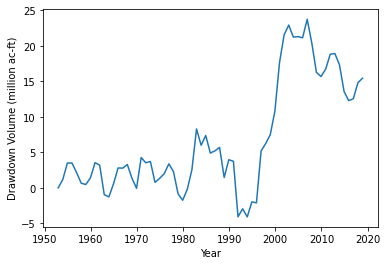

In [ ]:
#@markdown ### **Run this cell to calculate storage depletion curve**
#@markdown *Specify the storage coefficient of the aquifer*
storage_coefficient = 0.07 #@param {type:"number"}

imputed_raster = nc.Dataset('/content/Datasets/'+raster_file)

# Calculate the area of the aquifer
yRes = abs(round(imputed_raster['lat'][0] - imputed_raster['lat'][1], 7)) # this assumes all cells will be the same size in one dimension (all cells will have same x-component)
xRes = abs(round(imputed_raster['lon'][0] - imputed_raster['lon'][1], 7))
area = 0
# Loop through each y row
for y in range(imputed_raster.dimensions['lat'].size):
  # Define the upper and lower bounds of the row
  mylatmax = math.radians(imputed_raster['lat'][y] + (yRes/2))
  mylatmin = math.radians(imputed_raster['lat'][y] - (yRes/2))

  # Count how many cells in each row are in aquifer (i.e. and, therefore, not nan)
  xCount = 0
  for x in range(imputed_raster.dimensions['lon'].size):
    if not math.isnan(imputed_raster['tsvalue'][0, y, x]):
      xCount += 1
  
  # Area calculated based on the equation found here: https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
  #     (pi/180) * R^2 * |lon1-lon2| * |sin(lat1)-sin(lat2)| 
  area += (3958.8*5280)**2 * math.radians(xRes * xCount) * abs((math.sin(mylatmin) - math.sin(mylatmax)))
print("The area of the aquifer is %.1f million square feet.\n" %(area/10**6))

# Calculate total drawdown volume at each time step
drawdown_grid = np.zeros((imputed_raster.dimensions['time'].size, imputed_raster.dimensions['lat'].size, imputed_raster.dimensions['lon'].size))
drawdown_volume = np.zeros(imputed_raster.dimensions['time'].size)
for t in range(imputed_raster.dimensions['time'].size):
  drawdown_grid[t, :, :] = imputed_raster['tsvalue'][t, :, :] - imputed_raster['tsvalue'][0, :, :] #Calculate drawdown at time t by subtracting original WTE at time 0
  drawdown_volume[t] = np.nanmean(drawdown_grid[t, :, :] * storage_coefficient * area) # Average drawdown across entire aquifer x storage_coefficient x area of aquifer

# Plot storage depletion curve
x_data = pd.Series(imputed_raster['time'][:], dtype=int).apply(lambda x: datetime.datetime.fromordinal(x)) # Convert from days since 0001-01-01 00:00:00
y_data = drawdown_volume/(43560*10**6) # Convert to million ac-ft
plt.plot(x_data,y_data)
plt.xlabel("Year")
plt.ylabel("Drawdown Volume (million ac-ft)")
plt.show()

### <font color='dimgray'>Compare to GRACE</font>

In [ ]:
#@markdown ### **Run this cell to upload a GRACE csv file**

uploaded = files.upload()
wellsFile = ''.join(uploaded)
GRACE = pd.read_csv(wellsFile)

Saving central-valley-regional-average-water-storage-anomaly.csv to central-valley-regional-average-water-storage-anomaly.csv


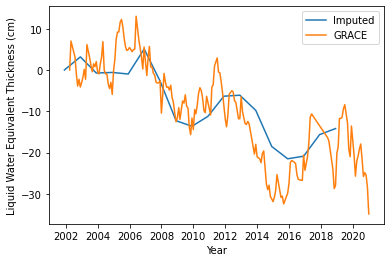

In [ ]:
#@markdown ### **Specify paramters and run the cell to create comparison plot of GRACE and imputed data**
#@markdown *Specify system of measurement for imputed data*
units = "English" #@param ["English", "Metric"]
unit_coefficient = 1
if units == "English": unit_coefficient = 0.3048
#@markdown *Specify what year to start plotting the imputed data*
#start_step = 500
start_year = 2001 #@param {type:"integer"}
try: 
  start_index = x_data[x_data.dt.year == start_year].index[0] # index of 1st item from start_year
except IndexError: 
  print('Your file may not have data in that year. Try a different start year.')
  sys.exit()

# Set up time series data from imputed drawdown volume and GRACE
x1 = x_data[start_index:]
y1 = ( drawdown_volume[start_index:] - drawdown_volume[start_index] ) / area * unit_coefficient * 100 # water level equivalent in cm
x2 = GRACE['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))  # milliseconds since epoch converted to date
y2 = GRACE['Groundwater Storage (Calculated)'][0:] - GRACE['Groundwater Storage (Calculated)'][0]  # water level equivalent in cm

plt.plot(x1,y1, label="Imputed")
plt.plot(x2,y2, label="GRACE")
plt.xlabel("Year")
plt.ylabel("Liquid Water Equivalent Thickness (cm)")
plt.legend()
plt.savefig('GRACE_comp_'+str(storage_coefficient)+'.png')
plt.show()

## **Retrieve Files**
1. Check the 'Files' panel on the left for your new files. 
2. Go to the 'Datasets' folder to find the well_data.nc, Well_Data_Imputed.pickle, and 06_Error_Metrics.h5 files. 
3. Click the three dots next to each file to download it.
*(Hit the refresh button if you do not see the new file initially)*

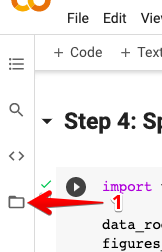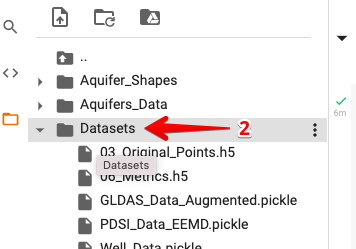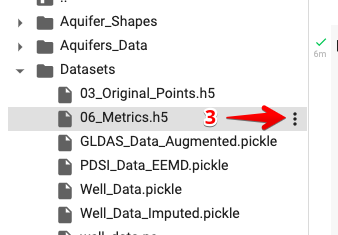

---

---

---

## **Appendix**

In [ ]:
#@markdown <a name="download"></a>
#@markdown ### **Allow Colab to Download Multiple Files**
#@markdown In order to download multiple files at once in Colab, you must allow Colab to do so. 
#@markdown 1. You can run this cell, which will download some small sample data files. 
#@markdown 2. A popup from your browser will appear, asking for permission to download multiple files. You only have to do this once per session. 
#@markdown 3. Afterwards, you can delete the downloaded files.

sample_data = ['/content/sample_data/california_housing_test.csv', 
               '/content/sample_data/california_housing_train.csv', 
               '/content/sample_data/anscombe.json']
for file in sample_data:
  files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>